In [1]:
import os
import pandas as pd
from scapy.all import rdpcap, IP, TCP, UDP, ICMP

In [2]:
pcap_folder = r"C:\Users\NSHAT\crossrealms - intern\honeypot - final AI engine\data\final data\honeypot_pcaps"

pcap_files = ["2025-01-04-four-days-of-scans-and-probes-and-web-traffic-hitting-my-web-server.pcap","honeypot_capture1.pcap","honeypot_capture2.pcap","honeypot_capture3.pcap","honeypot_traffic.pcap","old_honeypot_capture1.pcap","old_honeypot_capture2.pcap"]
pcap_paths = [os.path.join(pcap_folder, f) for f in pcap_files]

# General look at the files (basic packets meta data)

In [3]:
def parse_pcap(file_path):
    packets = rdpcap(file_path)
    rows = []
    last_ts = None  # for inter-packet time

    for pkt in packets:
        ts = pkt.time

        # Default values
        src_mac, dst_mac, eth_type = None, None, None
        src_ip, dst_ip, ttl, ip_flags, ip_hlen, dscp = None, None, None, None, None, None
        proto, sport, dport = None, None, None
        tcp_flags, seq, ack, win_size = None, None, None, None
        payload_len = 0
        inter_arrival = None
        length = len(pkt)

        # Ethernet layer
        if pkt.haslayer("Ether"):
            src_mac = pkt.src
            dst_mac = pkt.dst
            eth_type = hex(pkt.type)

        # IP layer
        if IP in pkt:
            src_ip = pkt[IP].src
            dst_ip = pkt[IP].dst
            ttl = pkt[IP].ttl
            ip_flags = pkt[IP].flags
            ip_hlen = pkt[IP].ihl
            dscp = pkt[IP].tos  # includes DSCP/ECN bits
            proto = pkt[IP].proto

            # TCP
            if TCP in pkt:
                proto = "TCP"
                sport = pkt[TCP].sport
                dport = pkt[TCP].dport
                tcp_flags = pkt[TCP].flags
                seq = pkt[TCP].seq
                ack = pkt[TCP].ack
                win_size = pkt[TCP].window
                payload_len = len(pkt[TCP].payload)

            # UDP
            elif UDP in pkt:
                proto = "UDP"
                sport = pkt[UDP].sport
                dport = pkt[UDP].dport
                payload_len = len(pkt[UDP].payload)

            # ICMP
            elif ICMP in pkt:
                proto = "ICMP"
                payload_len = len(pkt[ICMP].payload)

        # Inter-arrival time
        if last_ts is not None:
            inter_arrival = ts - last_ts
        last_ts = ts

        rows.append({
            "timestamp": ts,
            "inter_arrival": inter_arrival,
            "length": length,

            # Ethernet
            "src_mac": src_mac,
            "dst_mac": dst_mac,
            "eth_type": eth_type,

            # IP
            "src_ip": src_ip,
            "dst_ip": dst_ip,
            "ttl": ttl,
            "ip_flags": ip_flags,
            "ip_header_len": ip_hlen,
            "dscp": dscp,
            "protocol": proto,

            # Transport
            "src_port": sport,
            "dst_port": dport,
            "tcp_flags": tcp_flags,
            "seq_num": seq,
            "ack_num": ack,
            "window_size": win_size,
            "payload_len": payload_len
        })

    return pd.DataFrame(rows)


In [4]:
all_dfs = [parse_pcap(p) for p in pcap_paths]
df = pd.concat(all_dfs, ignore_index=True)

df.sort_values(by="timestamp", inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df.head()

,timestamp,inter_arrival,length,src_mac,dst_mac,eth_type,src_ip,dst_ip,ttl,ip_flags,ip_header_len,dscp,protocol,src_port,dst_port,tcp_flags,seq_num,ack_num,window_size,payload_len
0,1735689605.786838,None,54,64:64:9b:4f:37:00,00:16:3c:cb:72:42,0x800,185.242.226.28,203.161.44.208,247.0,,5.0,0.0,TCP,36989.0,16993.0,S,1.903121e+09,0.000000e+00,65535.0,0
1,1735689605.786871,0.000033,54,00:16:3c:cb:72:42,64:64:9b:4f:37:00,0x800,203.161.44.208,185.242.226.28,64.0,DF,5.0,0.0,TCP,16993.0,36989.0,RA,0.000000e+00,1.903121e+09,0.0,0
2,1735689607.386878,1.600007,74,00:16:3c:37:7a:83,00:16:3c:cb:72:42,0x800,203.161.44.39,203.161.44.208,64.0,DF,5.0,0.0,TCP,39536.0,445.0,S,2.573608e+09,0.000000e+00,64240.0,0
3,1735689607.386912,0.000034,54,00:16:3c:cb:72:42,00:16:3c:37:7a:83,0x800,203.161.44.208,203.161.44.39,64.0,DF,5.0,0.0,TCP,445.0,39536.0,RA,0.000000e+00,2.573608e+09,0.0,0
4,1735689607.387336,0.000424,74,00:16:3c:37:7a:83,00:16:3c:cb:72:42,0x800,203.161.44.39,203.161.44.208,64.0,DF,5.0,0.0,TCP,35390.0,5985.0,S,1.066392e+09,0.000000e+00,64240.0,0


In [6]:
df.shape

(244820, 20)

In [7]:
df["protocol"].value_counts()

protocol
TCP     232728
ICMP      9067
UDP       3023
41           1
Name: count, dtype: int64

In [8]:
df["src_ip"].value_counts().head(10)

src_ip
203.161.44.208    91338
10.0.1.4          29078
203.161.44.39     23751
168.63.129.16     14340
156.146.62.45      7326
46.17.96.38        2927
160.44.201.156     1968
79.124.62.230      1623
79.124.62.122      1528
79.124.62.134      1510
Name: count, dtype: int64

In [9]:
df["dst_ip"].value_counts().head(10)

dst_ip
203.161.44.208    100349
10.0.1.4           24053
203.161.44.39      23751
168.63.129.16      19930
156.146.62.45       6108
103.77.224.85       2963
160.44.201.156      2206
46.17.96.38         1469
83.222.191.58       1273
83.222.191.74       1256
Name: count, dtype: int64

In [10]:
df["length"].describe()

count    244820.000000
mean        121.881599
std         237.134805
min          42.000000
25%          54.000000
50%          58.000000
75%          74.000000
max        2962.000000
Name: length, dtype: float64

In [11]:
df["tcp_flags"].value_counts().head(10)

tcp_flags
S      74522
RA     67744
A      33217
PA     16000
SA     13534
R      11404
FA     10331
FPA     3703
SE      2025
SEC      208
Name: count, dtype: int64

In [12]:
df.groupby(["src_ip", "dst_ip"]).size().sort_values(ascending=False).head(10)

src_ip          dst_ip        
203.161.44.39   203.161.44.208    23751
203.161.44.208  203.161.44.39     23751
10.0.1.4        168.63.129.16     19930
168.63.129.16   10.0.1.4          14340
156.146.62.45   203.161.44.208     7326
203.161.44.208  156.146.62.45      6108
                103.77.224.85      2963
46.17.96.38     203.161.44.208     2927
10.0.1.4        160.44.201.156     2206
160.44.201.156  10.0.1.4           1968
dtype: int64

# flow level features

In [13]:
from scapy.all import rdpcap, TCP, UDP, IP
import pandas as pd
from collections import defaultdict
import statistics
import os
import numpy as np  # needed for np.mean, np.std, np.var

def safe_int(x, default=0):
    try:
        return int(x)
    except Exception:
        return default

def safe_float(x, default=0.0):
    try:
        return float(x)
    except Exception:
        return default

def list_stats(nums):
    """Return (sum, max, min, mean, std) as Python floats/ints for list nums."""
    if not nums:
        return 0.0, 0.0, 0.0, 0.0, 0.0
    s = sum(nums)
    mx = max(nums)
    mn = min(nums)
    mean_v = s / len(nums)
    try:
        std_v = statistics.pstdev(nums)
    except Exception:
        std_v = 0.0
    return safe_float(s), safe_float(mx), safe_float(mn), safe_float(mean_v), safe_float(std_v)

def diffs(sorted_ts):
    """Return list of inter-arrival times (differences) from a sorted list of timestamps."""
    if not sorted_ts or len(sorted_ts) == 1:
        return []
    return [safe_float(t2 - t1) for t1, t2 in zip(sorted_ts[:-1], sorted_ts[1:])]

def get_bulk_stats(lengths, timestamps, iat_threshold=1.0):
    """
    Detect bulk bursts based on inter-arrival time threshold.
    Return average bytes per bulk, average packets per bulk, average bulk rate.
    """
    if not lengths or not timestamps or len(lengths) != len(timestamps):
        return 0, 0, 0

    bursts = []
    current_burst_bytes = 0
    current_burst_packets = 0
    burst_start_time = timestamps[0]

    for i in range(len(timestamps)):
        if i == 0:
            current_burst_bytes = lengths[i]
            current_burst_packets = 1
            burst_start_time = timestamps[i]
        else:
            iat = timestamps[i] - timestamps[i - 1]
            if iat <= iat_threshold:
                current_burst_bytes += lengths[i]
                current_burst_packets += 1
            else:
                burst_duration = timestamps[i - 1] - burst_start_time
                if burst_duration > 0:
                    bulk_rate = current_burst_bytes / burst_duration
                else:
                    bulk_rate = 0
                bursts.append({
                    'bytes': current_burst_bytes,
                    'packets': current_burst_packets,
                    'duration': burst_duration,
                    'rate': bulk_rate
                })
                current_burst_bytes = lengths[i]
                current_burst_packets = 1
                burst_start_time = timestamps[i]

    burst_duration = timestamps[-1] - burst_start_time
    if burst_duration > 0:
        bulk_rate = current_burst_bytes / burst_duration
    else:
        bulk_rate = 0
    bursts.append({
        'bytes': current_burst_bytes,
        'packets': current_burst_packets,
        'duration': burst_duration,
        'rate': bulk_rate
    })

    if not bursts:
        return 0, 0, 0

    avg_bytes_bulk = np.mean([b['bytes'] for b in bursts])
    avg_packets_bulk = np.mean([b['packets'] for b in bursts])
    avg_bulk_rate = np.mean([b['rate'] for b in bursts])

    return safe_int(avg_bytes_bulk), safe_int(avg_packets_bulk), safe_int(avg_bulk_rate)

def extract_flows(pcap_file, only_tcp_udp=True):
    if not os.path.exists(pcap_file):
        raise FileNotFoundError(f"PCAP not found: {pcap_file}")

    packets = rdpcap(pcap_file)
    flows = defaultdict(lambda: {
        "fwd_packet_lengths": [],
        "bwd_packet_lengths": [],
        "fwd_timestamps": [],
        "bwd_timestamps": [],
        "fwd_flags": defaultdict(int),
        "bwd_flags": defaultdict(int),
        "fwd_packets": [],
        "bwd_packets": [],
        "all_packets": []
    })

    for pkt in packets:
        if not pkt.haslayer(IP):
            continue
        ip = pkt[IP]
        proto = safe_int(ip.proto)
        src = ip.src
        dst = ip.dst
        sport = None
        dport = None
        flags = None
        if proto == 6 and pkt.haslayer(TCP):
            sport = safe_int(pkt[TCP].sport)
            dport = safe_int(pkt[TCP].dport)
            flags = pkt[TCP].flags
        elif proto == 17 and pkt.haslayer(UDP):
            sport = safe_int(pkt[UDP].sport)
            dport = safe_int(pkt[UDP].dport)
            flags = None
        else:
            if only_tcp_udp:
                continue
            sport = 0
            dport = 0

        fwd_key = (src, dst, sport, dport, proto)
        bwd_key = (dst, src, dport, sport, proto)

        if fwd_key in flows:
            direction = "fwd"
            key = fwd_key
        elif bwd_key in flows:
            direction = "bwd"
            key = bwd_key
        else:
            direction = "fwd"
            key = fwd_key

        pkt_len = safe_int(len(pkt))
        ts = safe_float(getattr(pkt, "time", 0.0))
        if direction == "fwd":
            flows[key]["fwd_packet_lengths"].append(pkt_len)
            flows[key]["fwd_timestamps"].append(ts)
            flows[key]["fwd_packets"].append(pkt)
            flows[key]["all_packets"].append(pkt)
            if flags is not None:
                try:
                    flows[key]["fwd_flags"][int(flags)] += 1
                except Exception:
                    flows[key]["fwd_flags"]["other"] += 1
        else:
            flows[key]["bwd_packet_lengths"].append(pkt_len)
            flows[key]["bwd_timestamps"].append(ts)
            flows[key]["bwd_packets"].append(pkt)
            flows[key]["all_packets"].append(pkt)
            if flags is not None:
                try:
                    flows[key]["bwd_flags"][int(flags)] += 1
                except Exception:
                    flows[key]["bwd_flags"]["other"] += 1

    rows = []
    for (src, dst, sport, dport, proto), data in flows.items():
        fwd_lens = [safe_int(x) for x in data["fwd_packet_lengths"]]
        bwd_lens = [safe_int(x) for x in data["bwd_packet_lengths"]]
        fwd_ts = sorted([safe_float(x) for x in data["fwd_timestamps"]])
        bwd_ts = sorted([safe_float(x) for x in data["bwd_timestamps"]])
        all_ts = sorted(fwd_ts + bwd_ts)
        (fwd_sum, fwd_max, fwd_min, fwd_mean, fwd_std) = list_stats(fwd_lens)
        (bwd_sum, bwd_max, bwd_min, bwd_mean, bwd_std) = list_stats(bwd_lens)
        fwd_iat_list = diffs(fwd_ts)
        bwd_iat_list = diffs(bwd_ts)
        flow_iat_list = diffs(all_ts)
        def iat_stats(iat_list):
            if not iat_list:
                return 0.0, 0.0, 0.0, 0.0, 0.0
            s = sum(iat_list)
            mn = min(iat_list)
            mx = max(iat_list)
            mean_v = s / len(iat_list)
            std_v = statistics.pstdev(iat_list) if len(iat_list) > 0 else 0.0
            return safe_float(s), safe_float(mean_v), safe_float(std_v), safe_float(mx), safe_float(mn)
        flow_iat_total, flow_iat_mean, flow_iat_std, flow_iat_max, flow_iat_min = iat_stats(flow_iat_list)
        fwd_iat_total, fwd_iat_mean, fwd_iat_std, fwd_iat_max, fwd_iat_min = iat_stats(fwd_iat_list)
        bwd_iat_total, bwd_iat_mean, bwd_iat_std, bwd_iat_max, bwd_iat_min = iat_stats(bwd_iat_list)
        if all_ts:
            flow_duration = safe_int((all_ts[-1] - all_ts[0]) * 1000)
        else:
            flow_duration = 0
        flow_packets = data["all_packets"]
        fwd_packets = data["fwd_packets"]
        bwd_packets = data["bwd_packets"]
        row = {
            "Flow ID": f"{src}-{dst}-{sport}-{dport}-{proto}",
            "Source IP": src,
            "Source Port": safe_int(sport),
            "Destination IP": dst,
            "Destination Port": safe_int(dport),
            "Protocol": safe_int(proto),
            "Timestamp": all_ts[0] if all_ts else 0.0,
            "Flow Duration": flow_duration,
            "Total Fwd Packets": safe_int(len(fwd_lens)),
            "Total Backward Packets": safe_int(len(bwd_lens)),
            "Total Length of Fwd Packets": safe_float(fwd_sum),
            "Total Length of Bwd Packets": safe_float(bwd_sum),
            "Fwd Packet Length Max": safe_float(fwd_max),
            "Fwd Packet Length Min": safe_float(fwd_min),
            "Fwd Packet Length Mean": safe_float(fwd_mean),
            "Fwd Packet Length Std": safe_float(fwd_std),
            "Bwd Packet Length Max": safe_float(bwd_max),
            "Bwd Packet Length Min": safe_float(bwd_min),
            "Bwd Packet Length Mean": safe_float(bwd_mean),
            "Bwd Packet Length Std": safe_float(bwd_std),
            "Flow Bytes/s": safe_float((fwd_sum + bwd_sum) / flow_duration) if flow_duration > 0 else 0,
            "Flow Packets/s": safe_float((len(fwd_packets) + len(bwd_packets)) / flow_duration) if flow_duration > 0 else 0,
            "Flow IAT Mean": safe_float(flow_iat_mean),
            "Flow IAT Std": safe_float(flow_iat_std),
            "Flow IAT Max": safe_float(flow_iat_max),
            "Flow IAT Min": safe_float(flow_iat_min),
            "Fwd IAT Total": safe_float(fwd_iat_total),
            "Fwd IAT Mean": safe_float(fwd_iat_mean),
            "Fwd IAT Std": safe_float(fwd_iat_std),
            "Fwd IAT Max": safe_float(fwd_iat_max),
            "Fwd IAT Min": safe_float(fwd_iat_min),
            "Bwd IAT Total": safe_float(bwd_iat_total),
            "Bwd IAT Mean": safe_float(bwd_iat_mean),
            "Bwd IAT Std": safe_float(bwd_iat_std),
            "Bwd IAT Max": safe_float(bwd_iat_max),
            "Bwd IAT Min": safe_float(bwd_iat_min),
            "Fwd PSH Flags": sum(1 for p in fwd_packets if p.haslayer(TCP) and p[TCP].flags & 0x08),
            "Bwd PSH Flags": sum(1 for p in bwd_packets if p.haslayer(TCP) and p[TCP].flags & 0x08),
            "Fwd URG Flags": sum(1 for p in fwd_packets if p.haslayer(TCP) and p[TCP].flags & 0x20),
            "Bwd URG Flags": sum(1 for p in bwd_packets if p.haslayer(TCP) and p[TCP].flags & 0x20),
            "Fwd Header Length": sum(len(p[TCP]) if p.haslayer(TCP) else len(p[UDP]) for p in fwd_packets),
            "Bwd Header Length": sum(len(p[TCP]) if p.haslayer(TCP) else len(p[UDP]) for p in bwd_packets),
            "Fwd Packets/s": safe_float(len(fwd_packets) / flow_duration) if flow_duration > 0 else 0,
            "Bwd Packets/s": safe_float(len(bwd_packets) / flow_duration) if flow_duration > 0 else 0,
            "Min Packet Length": min([len(p) for p in flow_packets]) if flow_packets else 0,
            "Max Packet Length": max([len(p) for p in flow_packets]) if flow_packets else 0,
            "Packet Length Mean": safe_float(np.mean([len(p) for p in flow_packets])) if flow_packets else 0,
            "Packet Length Std": safe_float(np.std([len(p) for p in flow_packets])) if flow_packets else 0,
            "Packet Length Variance": safe_float(np.var([len(p) for p in flow_packets])) if flow_packets else 0,
            "FIN Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x01),
            "SYN Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x02),
            "RST Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x04),
            "PSH Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x08),
            "ACK Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x10),
            "URG Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x20),
            "CWE Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x80),
            "ECE Flag Count": sum(1 for p in flow_packets if p.haslayer(TCP) and p[TCP].flags & 0x40),
            "Down/Up Ratio": safe_float(len(bwd_packets) / len(fwd_packets)) if len(fwd_packets) > 0 else 0,
            "Average Packet Size": safe_float((fwd_sum + bwd_sum) / (len(fwd_packets) + len(bwd_packets))) if (len(fwd_packets) + len(bwd_packets)) > 0 else 0,
            "Avg Fwd Segment Size": safe_float(fwd_mean),
            "Avg Bwd Segment Size": safe_float(bwd_mean),
            "Fwd Header Length.1": sum(len(p[TCP]) if p.haslayer(TCP) else len(p[UDP]) for p in fwd_packets),
            "Fwd Avg Bytes/Bulk": get_bulk_stats(fwd_lens, fwd_ts)[0],
            "Fwd Avg Packets/Bulk": get_bulk_stats(fwd_lens, fwd_ts)[1],
            "Fwd Avg Bulk Rate": get_bulk_stats(fwd_lens, fwd_ts)[2],
            "Bwd Avg Bytes/Bulk": get_bulk_stats(bwd_lens, bwd_ts)[0],
            "Bwd Avg Packets/Bulk": get_bulk_stats(bwd_lens, bwd_ts)[1],
            "Bwd Avg Bulk Rate": get_bulk_stats(bwd_lens, bwd_ts)[2],
            "Subflow Fwd Packets": safe_int(len(fwd_packets)),
            "Subflow Fwd Bytes": safe_int(fwd_sum),
            "Subflow Bwd Packets": safe_int(len(bwd_packets)),
            "Subflow Bwd Bytes": safe_int(bwd_sum),
            "Init_Win_bytes_forward": fwd_packets[0][TCP].window if (fwd_packets and fwd_packets[0].haslayer(TCP)) else 0,
            "Init_Win_bytes_backward": bwd_packets[0][TCP].window if (bwd_packets and bwd_packets[0].haslayer(TCP)) else 0,
            "act_data_pkt_fwd": sum(1 for p in fwd_packets if len(p) > 0),
            "min_seg_size_forward": min([len(p) for p in fwd_packets]) if fwd_packets else 0
        }
        if len(all_ts) > 1:
            gaps = np.diff(sorted(all_ts))
            active_times = gaps[gaps <= 1]
            idle_times = gaps[gaps > 1]
            row["Active Mean"] = safe_float(np.mean(active_times)) if len(active_times) else 0
            row["Active Std"] = safe_float(np.std(active_times)) if len(active_times) else 0
            row["Active Max"] = safe_float(np.max(active_times)) if len(active_times) else 0
            row["Active Min"] = safe_float(np.min(active_times)) if len(active_times) else 0
            row["Idle Mean"] = safe_float(np.mean(idle_times)) if len(idle_times) else 0
            row["Idle Std"] = safe_float(np.std(idle_times)) if len(idle_times) else 0
            row["Idle Max"] = safe_float(np.max(idle_times)) if len(idle_times) else 0
            row["Idle Min"] = safe_float(np.min(idle_times)) if len(idle_times) else 0
        else:
            row["Active Mean"] = row["Active Std"] = row["Active Max"] = row["Active Min"] = 0
            row["Idle Mean"] = row["Idle Std"] = row["Idle Max"] = row["Idle Min"] = 0
        rows.append(row)
    df = pd.DataFrame(rows)
    return df

df = pd.concat([extract_flows(os.path.join(pcap_folder, f)) for f in pcap_files], ignore_index=True)

print("Final DataFrame shape:", df.shape)
df.head()

Final DataFrame shape: (70621, 84)


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,185.242.226.28-203.161.44.208-36989-16993-6,185.242.226.28,36989,203.161.44.208,16993,6,1.735690e+09,0,1,1,...,1,54,0.000033,0.000000,0.000033,0.000033,0.000000,0.000000,0.000000,0.000000
1,203.161.44.39-203.161.44.208-39536-445-6,203.161.44.39,39536,203.161.44.208,445,6,1.735690e+09,0,1,1,...,1,74,0.000034,0.000000,0.000034,0.000034,0.000000,0.000000,0.000000,0.000000
2,203.161.44.39-203.161.44.208-35390-5985-6,203.161.44.39,35390,203.161.44.208,5985,6,1.735690e+09,55011528,2,2,...,2,74,0.000013,0.000003,0.000016,0.000010,55011.528712,0.000000,55011.528712,55011.528712
3,203.161.44.39-203.161.44.208-44078-22-6,203.161.44.39,44078,203.161.44.208,22,6,1.735690e+09,0,1,1,...,1,74,0.000033,0.000000,0.000033,0.000033,0.000000,0.000000,0.000000,0.000000
4,193.200.78.250-203.161.44.208-46075-80-6,193.200.78.250,46075,203.161.44.208,80,6,1.735690e+09,31495,1,6,...,1,54,0.000043,0.000000,0.000043,0.000043,6.299036,5.495464,16.128037,1.031166


## Clustring 

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [15]:
features = [
      'Flow Bytes/s',
       'Flow Packets/s',
    'Flow Duration',
     'Down/Up Ratio',
     'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
      'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean',
    "Bwd Packet Length Mean",
    "Avg Bwd Segment Size", "Average Packet Size","Flow IAT Max",
    "Bwd Packet Length Max",
    "Idle Mean",
    "Fwd IAT Max"
]
from sklearn.preprocessing import RobustScaler
X = df[features].fillna(0)  # fill missing values if any
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

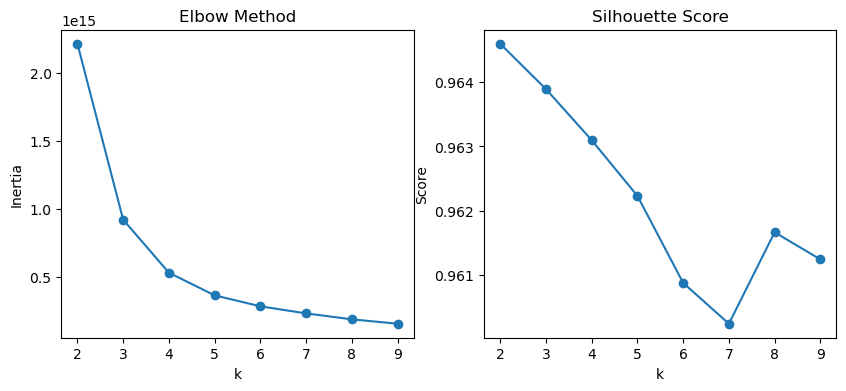

In [16]:
inertias = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.show()
# to check wahts the best k value

## so we choose the value 4 for k       --         kmeans

In [57]:
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

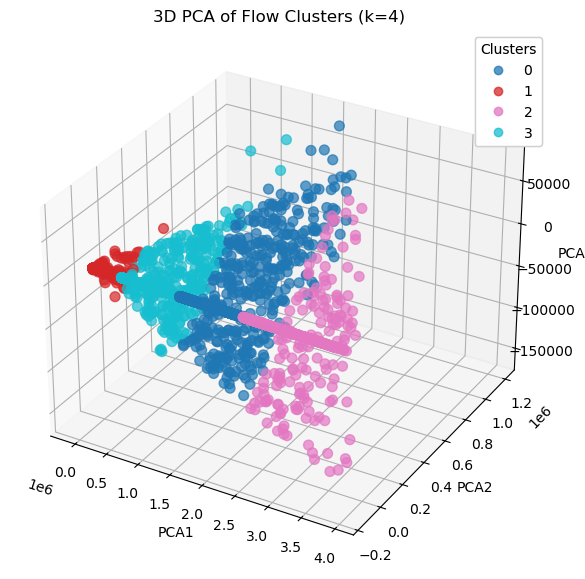

In [58]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

# reduce to 3 dimensions
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df['PCA1'] = X_pca[:,0]
df['PCA2'] = X_pca[:,1]
df['PCA3'] = X_pca[:,2]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['PCA1'], df['PCA2'], df['PCA3'], 
                     c=df['Cluster'], cmap='tab10', s=50, alpha=0.7)

ax.set_title(f"3D PCA of Flow Clusters (k={k_opt})")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")


legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

In [75]:
cluster_summary = df.groupby('Cluster')[features].mean()
#print(cluster_summary)
cluster_summary.head()

         Flow Bytes/s  Flow Packets/s  Flow Duration  Down/Up Ratio  \
Cluster                                                               
0            0.000002    3.775364e-08   1.734663e+08       0.996676   
1           49.872946    1.746110e-01   2.634154e+05       0.872734   
2            0.000001    1.729754e-08   2.601988e+08       0.991228   
3            0.000004    6.508462e-08   8.385307e+07       1.010487   

         Min Packet Length  Max Packet Length  Packet Length Mean  \
Cluster                                                             
0                54.355114          74.269176           64.182156   
1                57.965175         140.540377           75.937572   
2                54.215539          73.973684           64.099624   
3                54.080262          74.333532           63.960762   

         Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
Cluster                                                                      

## training a model

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score , classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

In [61]:
feature_cols = [col for col in df.columns if col not in 
                ['Flow ID', 'Source IP', 'Destination IP', 
                 'Source Port', 'Destination Port', 'Timestamp', 'Cluster','PCA1', 'PCA2', 'PCA3']]

X = df[feature_cols]
y = df['Cluster'] 

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=feature_cols)

In [65]:
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [66]:
X_train_resampled = pd.DataFrame(X_train_resampled, columns=feature_cols)

In [67]:
print("Before SMOTE:", y.value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())

Before SMOTE: Cluster
1    66733
3     1682
0     1408
2      798
Name: count, dtype: int64
After SMOTE: Cluster
1    46712
3    46712
0    46712
2    46712
Name: count, dtype: int64


In [68]:
rf = RandomForestClassifier(n_estimators=200,max_depth=None,random_state=42, class_weight="balanced")

In [69]:
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [70]:
y_pred = rf.predict(X_test_scaled)

## Evaluating the models performence

In [71]:
print("==== Test Performance ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")

==== Test Performance ====
Accuracy: 0.9995
Precision (macro): 0.9921
Recall (macro): 0.9950
F1-score (macro): 0.9935


In [72]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       422
           1       1.00      1.00      1.00     20021
           2       0.98      1.00      0.99       239
           3       1.00      0.99      0.99       505

    accuracy                           1.00     21187
   macro avg       0.99      1.00      0.99     21187
weighted avg       1.00      1.00      1.00     21187



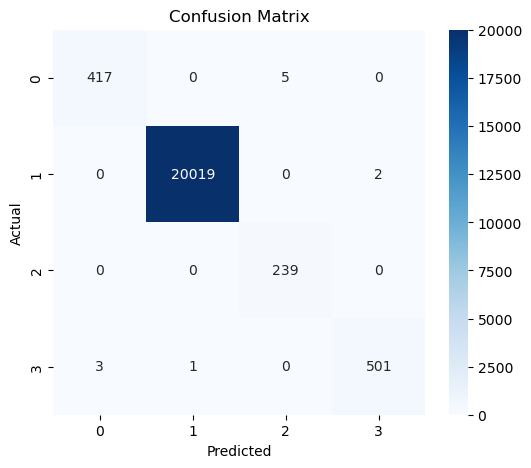

In [73]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",xticklabels=set(y_test), yticklabels=set(y_test))
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()